In [831]:
import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
import time
import sys

#Scikit Learn
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report

from statsmodels.stats.outliers_influence import variance_inflation_factor


sys.path.insert(0, 'c:\\Users\\ingal\\Documents\\Data Science Work\\Data Scientist Take Home Exam - Recommendations')

from src.Imputation import lowerSalaryNoAgeImpute, designationNoAgeImputation, AgeNoMonthlyIncomeImputation, medianPreferredPropertyStarImputation, NumberOfTripsImputation, missingChildrenImputation

%matplotlib inline

In [832]:
tourism_df = pd.read_csv('../data/intermediate/cleaned_tourism.csv',index_col=0)
tourism_df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


## Feature Engineering

In [833]:
# drop columns that don't pertain to the customer's attribute or are arbitraty for our model
tourism_df.drop(columns= ['TypeofContact','DurationOfPitch','NumberOfFollowups','PitchSatisfactionScore'], axis=1, inplace=True)

In [834]:
# For us to categorize our customers, we care about when a profile was correctly pitched, not when it wasn't. So we filter for that. We also don't need CutomserID, the model shouldn't learn to predict based on ID numbers.

tourism_df = tourism_df[tourism_df['ProdTaken'] == 1].reset_index()
tourism_df.drop(columns = ['ProdTaken', 'CustomerID'], axis=1,inplace=True)

In [835]:
# dropping the Occupation column because the values are clear, they are imbalanced, and could have led to confusion during the process (do they work at a large business or own a large business? Where is hourly? etc.)
tourism_df.drop(columns = ['Occupation'], axis=1,inplace=True)

This is a textbook example of Mult-Class Classification. A customer can only belong to one product, we do not want to pitch multiple products for them.

In [836]:
tourism_df
X_df = tourism_df.drop(columns=['ProductPitched'],axis=1)
# dummy variables for Gender, MaritalStatus, and Designation
X_df = pd.get_dummies(X_df)

Time to one-hot encode the categorical features that are numerical. This will help avoid any sort of ranking in the model. 

Features: CityTier and PreferredPropertyStar

In [837]:
X_df = pd.get_dummies(X_df, columns=['CityTier','PreferredPropertyStar']).drop(columns=['index'],axis=1)

In [838]:
# turn X into np array of values
X = X_df.values
X

array([[41.,  3.,  1., ...,  1.,  0.,  0.],
       [37.,  3.,  7., ...,  1.,  0.,  0.],
       [28.,  2.,  6., ...,  1.,  0.,  0.],
       ...,
       [52.,  4.,  7., ...,  0.,  1.,  0.],
       [19.,  3.,  3., ...,  1.,  0.,  0.],
       [36.,  4.,  3., ...,  0.,  1.,  0.]])

In [842]:
# for y values we will use LabelEncoder from SciKit Learn to turn our categories into numerical values
le = LabelEncoder()
le.fit(tourism_df['ProductPitched'])
y = le.transform(tourism_df['ProductPitched'])

In [843]:
#these are the classes that we changed into values
le.classes_

array(['Basic', 'Deluxe', 'King', 'Standard', 'Super Deluxe'],
      dtype=object)

In [844]:
y

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 3, 0, 0, 3, 0, 0, 1, 1, 0, 1, 3,
       0, 1, 3, 0, 0, 0, 0, 1, 1, 3, 3, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 3,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 3, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2,
       1, 0, 0, 1, 2, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3,
       3, 0, 4, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 3, 3, 3, 1,
       0, 0, 0, 0, 1, 4, 0, 1, 0, 3, 4, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 3,
       0, 1, 0, 3, 3, 0, 0, 3, 4, 0, 1, 1, 0, 1, 3, 0, 0, 0, 3, 0, 3, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 3, 1, 0, 0, 3, 1, 0, 1, 0, 0, 0,
       0, 0, 4, 1, 1, 0, 0, 3, 3, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 3, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 2, 3, 0, 0, 3, 0, 0, 1, 1, 0, 1, 3, 0, 1, 3, 0, 0,
       0, 0, 1, 1, 3, 3, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,

## Custom Transformers for Preprocessing Functions

In [ ]:
def lowerSalaryNoAgeImpute(X):
    """
    This function will replace any NaN Age value that also has a Monthly income of less than 19000 with the mean age of the partitioned data that has an income less than 19000. 

    Args:
        df (Dataframe): Tourism dataframe

    Returns:
        dataframe: Dataframe with some Age NaN values replaced based on their monthly income being less than 19000
    """
    df = pd.DataFrame(X)

    low_income_age = round(df[df[6] > 19000][0].mean(), 0)

    mask =  (df[0].isna()) & (df[6] < 19000)    

    df.loc[mask,0] = low_income_age
    
    X = df.values

    return X

In [845]:
Age_low_salary_NaN = FunctionTransformer(lowerSalaryNoAgeImpute, validate=True)
Age_NaN = FunctionTransformer(designationNoAgeImputation, validate=True)
Income_NaN = FunctionTransformer(AgeNoMonthlyIncomeImputation, validate=True)

## Model Selection

I will be using XGBoost for my model choice. Since the assignment doesn't want us to check out different models, I prefer to use an ensemble model, which generally performs better than an individual model. Then when choosing between Random Forest (another ensemble) and XGBoost, generally XGBoost is faster and since boosting has better performance than bagging (Random Forest), I will choose the better on average of the two models. XGBoost is currently one of the best ensemble methods available. Additionally, XGBoost's default models are regularized, so overfitting is more difficult. Finally, XGBoost has hyperparameters to scale imbalanced data, which we definitely have so this will be a great Algorithm for this project. 

We will be using the Scikit-learn wrapper for XGBoost: XGBClassifier. Additionally, we will create a ML pipeline using Scikit-learn so we can perform our NaN fills on the partitioned dataset to avoid the data leakage.

In [846]:
# Training/Testing Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [847]:
#create a pipeline 
# model = XGBClassifier()
pipeline = Pipeline([
    # ('Age_low_salary_NaN',Age_low_salary_NaN),
    # ('Age_NaN',Age_NaN),
    # ('Income_NaN',Income_NaN),
    ('Children_Trips_Star_NaN',SimpleImputer(strategy = 'median')),
    ('Standard_Scalar',StandardScaler()), 
    ('model', KNeighborsClassifier())
])

## Baseline Model

In [848]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('Children_Trips_Star_NaN', SimpleImputer(strategy='median')),
                ('Standard_Scalar', StandardScaler()),
                ('model', KNeighborsClassifier())])

In [849]:
y_pred = pipeline.predict(X_test)

In [850]:
# Plot confusion matrix
def confusionMatrix(y_test,y_pred):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
        confusion_matrix(y_test, y_pred),
        display_labels=["Basic", "Deluxe", "King", "Standard", "Super Deluxe"], 
    )

    cmp.plot(ax=ax)
    plt.show();
    return

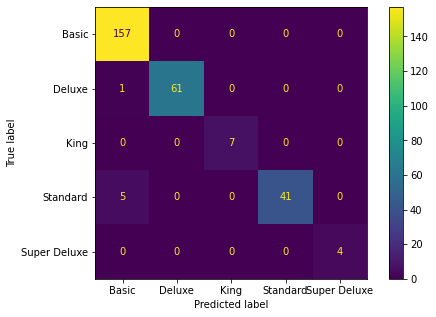

In [851]:
confusionMatrix(y_test,y_pred)

#### Precision/Recall F1 Scores

Since we have a high class imbalance, F1 scores are the right choice for our metric as it considers both precision and recall. To get a high F1, both false positives and false negatives must be low. Other measures of performance for classification my give us high scores with a high enough number of false positives. 

In [852]:
print(classification_report(y_test, y_pred, target_names=["Basic", "Deluxe", "King", "Standard", "Super Deluxe"]))

              precision    recall  f1-score   support

       Basic       0.96      1.00      0.98       157
      Deluxe       1.00      0.98      0.99        62
        King       1.00      1.00      1.00         7
    Standard       1.00      0.89      0.94        46
Super Deluxe       1.00      1.00      1.00         4

    accuracy                           0.98       276
   macro avg       0.99      0.98      0.98       276
weighted avg       0.98      0.98      0.98       276



### Cross-Validation

In [853]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1,error_score="raise")
# summarize performance
print('Mean F1 weighted: %.5f' % mean(scores))

Mean F1 weighted: 0.99670


## Feature Selection

### Feature Significance

### MultiCollinearity

In [854]:
corr=X_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age,NumberOfPersonVisiting,NumberOfTrips,Passport,OwnCar,NumberOfChildrenVisiting,MonthlyIncome,Gender_Female,Gender_Male,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Designation_AVP,Designation_Executive,Designation_Manager,Designation_Senior Manager,Designation_VP,CityTier_1,CityTier_2,CityTier_3,PreferredPropertyStar_3.0,PreferredPropertyStar_4.0,PreferredPropertyStar_5.0
Age,1.000000,0.061713,0.093434,-0.006912,0.068902,0.063468,0.502517,-0.050635,0.050635,0.065152,0.151519,-0.189633,0.132601,-0.413205,0.154175,0.250527,0.214628,-0.041824,-0.053792,0.066754,0.054815,-0.007901,-0.084855
NumberOfPersonVisiting,0.061713,1.000000,0.187754,0.045721,0.041352,0.621791,0.312351,0.046451,-0.046451,0.027067,-0.015456,-0.003701,-0.046591,-0.024003,0.023869,0.027067,-0.004152,0.055637,-0.023427,-0.046194,-0.096752,0.029670,0.066461
NumberOfTrips,0.093434,0.187754,1.000000,0.000556,-0.013116,0.207184,0.120667,-0.085630,0.085630,0.015289,0.069034,-0.076477,-0.003228,-0.049098,0.103073,-0.056465,0.006974,0.017902,-0.044298,0.001524,0.002800,-0.044556,0.025582
Passport,-0.006912,0.045721,0.000556,1.000000,0.032625,0.040108,-0.061643,0.001628,-0.001628,0.021815,-0.023005,0.007110,0.018847,0.113911,-0.050056,-0.118620,0.018847,0.047415,-0.047009,-0.027252,0.075017,0.034332,-0.113876
OwnCar,0.068902,0.041352,-0.013116,0.032625,1.000000,0.038796,0.158618,-0.000801,0.000801,0.081666,-0.002024,-0.053852,0.119523,-0.090924,-0.000932,0.042534,0.088978,-0.038286,0.020438,0.029854,-0.024042,0.040351,-0.015890
NumberOfChildrenVisiting,0.063468,0.621791,0.207184,0.040108,0.038796,1.000000,0.274998,0.040020,-0.040020,-0.031478,0.040432,-0.017249,-0.000076,0.029938,-0.017334,-0.035824,0.036624,-0.052204,-0.012860,0.058981,-0.050766,0.046049,0.004832
MonthlyIncome,0.502517,0.312351,0.120667,-0.061643,0.158618,0.274998,1.000000,0.006787,-0.006787,0.042523,0.064918,-0.091152,0.249958,-0.525475,0.106563,0.334918,0.408352,-0.151270,-0.014132,0.160407,-0.021449,-0.021328,-0.010261
Gender_Female,-0.050635,0.046451,-0.085630,0.001628,-0.000801,0.040020,0.006787,1.000000,-1.000000,0.012543,-0.052604,0.041766,-0.052975,0.012855,-0.031591,0.012543,0.070410,-0.105734,0.050568,0.085079,-0.077362,0.148737,-0.050230
Gender_Male,0.050635,-0.046451,0.085630,-0.001628,0.000801,-0.040020,-0.006787,-1.000000,1.000000,-0.012543,0.052604,-0.041766,0.052975,-0.012855,0.031591,-0.012543,-0.070410,0.105734,-0.050568,-0.085079,0.077362,-0.148737,0.050230
MaritalStatus_Divorced,0.065152,0.027067,0.015289,0.021815,0.081666,-0.031478,0.042523,0.012543,-0.012543,1.000000,-0.292395,-0.403364,-0.058837,-0.093560,0.034513,0.086562,0.072122,0.050808,-0.032130,-0.037375,0.076700,-0.084140,-0.019288


- Children vs. Person : 62%
- Monthly Income vs. Age: 49%
- Executive vs Age: -40%
- Executive vs. Income 52%
- Male vs Female: 100%
- Married vs Single: 75%
- Single vs Divorsed 40%
- Manager vs Executive: 65%
- City1 vs City3: 90%
- Star3 vs Star5: 65%
- Star3 vs Star4: 53%
- Executive vs. Senior Manager: 48%

In [855]:
#Compute VIF data for each independent variable
vif = pd.DataFrame()
vif["features"] = X_df.columns
vif["vif_Factor"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
vif

MissingDataError: exog contains inf or nans

## Model Test Post Feature Selection

In [ ]:
X_df.columns

Index(['Age', 'NumberOfPersonVisiting', 'NumberOfTrips', 'Passport', 'OwnCar',
       'NumberOfChildrenVisiting', 'MonthlyIncome', 'Gender_Female',
       'Gender_Male', 'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'Designation_AVP', 'Designation_Executive',
       'Designation_Manager', 'Designation_Senior Manager', 'Designation_VP',
       'CityTier_1', 'CityTier_2', 'CityTier_3', 'PreferredPropertyStar_3.0',
       'PreferredPropertyStar_4.0', 'PreferredPropertyStar_5.0'],
      dtype='object')

In [ ]:
X_sel = X_df[['MonthlyIncome','Age', 'Designation_AVP', 'Designation_Executive',
       'Designation_Manager', 'Designation_Senior Manager', 'Designation_VP']].values

In [ ]:
# Training/Testing Split

X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.3, random_state=42)

In [ ]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
pipeline.score(X_test,y_test)

1.0

In [ ]:
confusion_matrix(y_test,y_pred)

array([[157,   0,   0,   0,   0],
       [  0,  62,   0,   0,   0],
       [  0,   0,   7,   0,   0],
       [  0,   0,   0,  46,   0],
       [  0,   0,   0,   0,   4]], dtype=int64)

In [ ]:
print(classification_report(y_test, y_pred, target_names=["Basic", "Deluxe", "King", "Standard", "Super Deluxe"]))

              precision    recall  f1-score   support

       Basic       1.00      1.00      1.00       157
      Deluxe       1.00      1.00      1.00        62
        King       1.00      1.00      1.00         7
    Standard       1.00      1.00      1.00        46
Super Deluxe       1.00      1.00      1.00         4

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



## Hyperparameter Tuning